# Cohort Analysis

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [17]:
df = pd.read_excel('data/online_retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [18]:
df.dropna(subset=['CustomerID'], inplace=True)

In [20]:
# We calculate an aggregate metric indicating how many orders were placed by each customer.
n_orders = df.groupby(['CustomerID'])['InvoiceNo'].nunique()


/var/folders/sl/c5pyww8j61j6_9_z4twp2ygc0000gn/T/ipykernel_90142/275234397.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(n_orders, kde=False, hist=True)


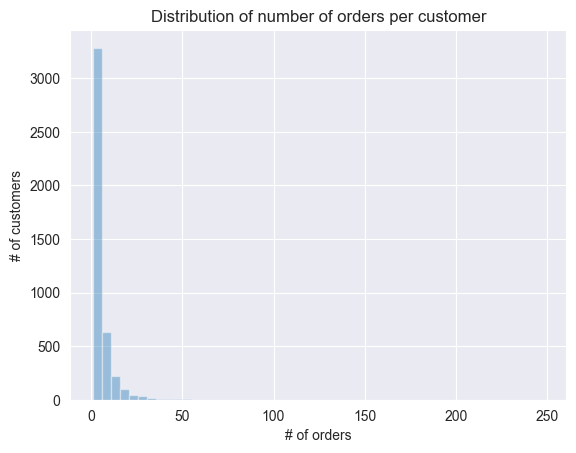

In [21]:
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

# COHORT ANALYSIS

In [22]:
df = df[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

In [23]:
#As the second step, we create the cohort and order_month variables. 
#The first one indicates the monthly cohort based on the first purchase date (calculated per customer). 
#The latter one is the truncated month of the purchase date.

df['order_month'] = df['InvoiceDate'].dt.to_period('M')  #Returns numpy array of python datetime.date objects.
df['cohort'] = df.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 




In [24]:
#data aggregation by cohort and count the number of unique customers in each group

df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [25]:
# pivotting the df_cohort table in a way that each row contains information about a given cohort and each column contains values for a certain period.

cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# RETENTION MATRIX

In [26]:
#To obtain the retention matrix, we need to divide the values each row by the row's first value,
#which is actually the cohort size — all customers who made their first purchase in the given month.

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


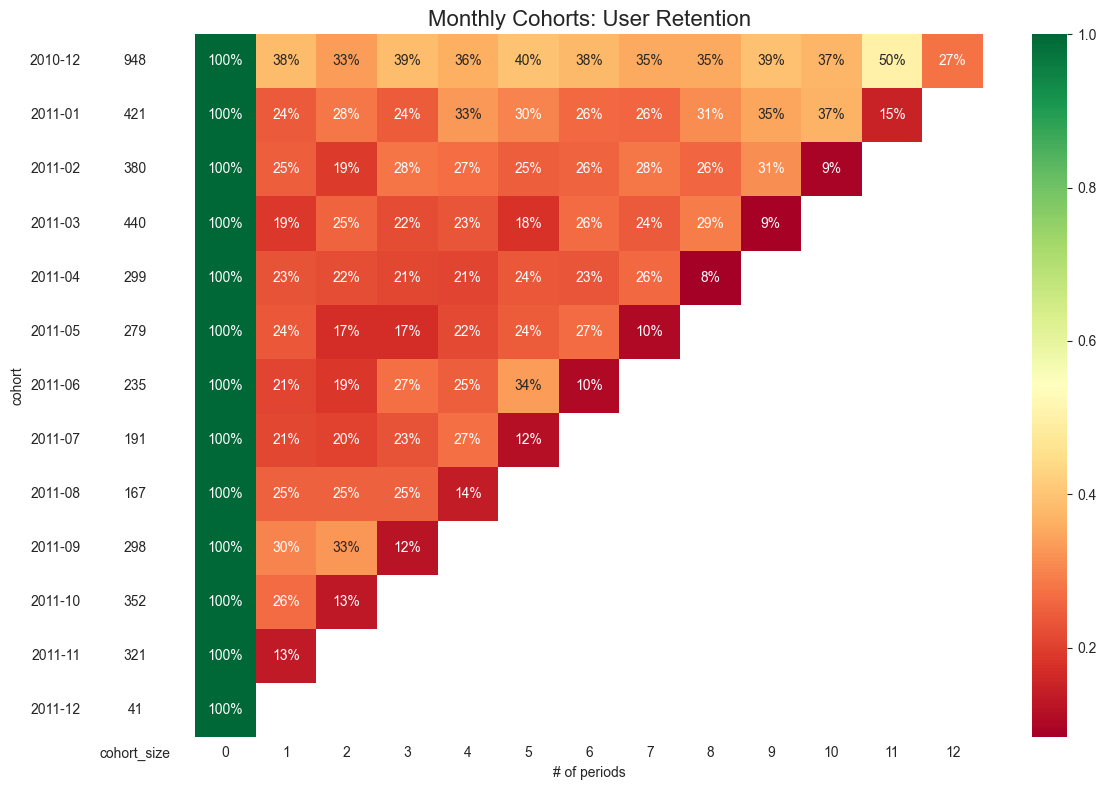

In [27]:
#heatmaps : one indicating the cohort size is using and a white only colormap — no coloring at all.

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

# INTERPRETATION